In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.mlab as mpll
import matplotlib as mpl
import glob
import os
from scipy.integrate import cumulative_trapezoid
import pathlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import chi2_contingency
from scipy import signal as sp
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import stats as st
import statistics
import math
from scipy.interpolate import UnivariateSpline # para interpolar
from scipy.signal import find_peaks

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta de la carpeta en Google Drive (ajusta según tu estructura)
carpeta_drive = "/content/drive/MyDrive/Ferromagnetismo/mediciones/datos ferro"

# Obtener lista de archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(carpeta_drive, "*.csv"))

# Verificar cuántos archivos hay
print(f"Se encontraron {len(archivos_csv)} archivos CSV.")

Se encontraron 113 archivos CSV.


# Curva de Histeresis

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


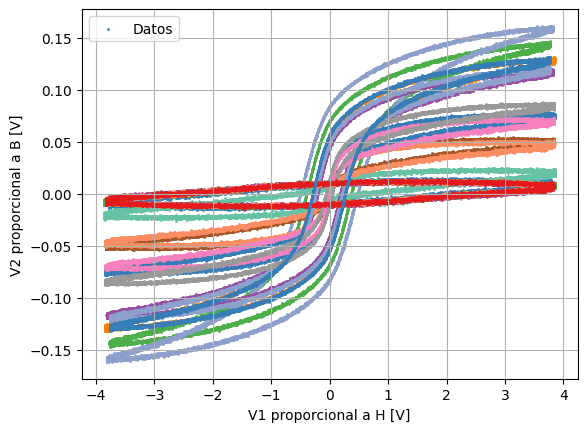

In [ ]:
import random
# Colores extraídos de tu imagen
colores_originales = [
    "#e41a1c",  # Rojo
    "#377eb8",  # Azul
    "#4daf4a",  # Verde
    "#984ea3",  # Violeta
    "#ff7f00",  # Naranja
    "#a65628",  # Marrón (lo podemos quitar si no lo quieres)
    "#f781bf",  # Rosa claro
    "#999999",  # Gris
    "#66c2a5",  # Verde agua
    "#fc8d62",  # Naranja suave
    "#8da0cb",  # Azul pastel
]

# Mezclar los colores para asignarlos de forma aleatoria
random.shuffle(colores_originales)

# Definir cuántos colores necesitamos
num_colores = len(range(0, len(archivos_csv), 5))
colores = colores_originales * (num_colores // len(colores_originales) + 1)  # Extiende si es necesario
colores = colores[:num_colores]  # Corta la lista para que tenga solo los necesarios


for idx, i in enumerate(range(0, len(archivos_csv), 5)):  #creo un for que agarra cada 5 archivos así no queda tan saturado el plot
    archivo = archivos_csv[i]
    df = pd.read_csv(archivo)  # Leer CSV
    H = df["tension_entrada"]
    B = df["tension_integrada"]-np.mean(df["tension_integrada"])
    plt.scatter(H, B, s=1,color=colores[idx])
    if i == 0: #para un solo archivo pongo la legend
        plt.legend(["Datos"])
    plt.xlabel("V1 proporcional a H [V]")
    plt.ylabel("V2 proporcional a B [V]")
    plt.grid()


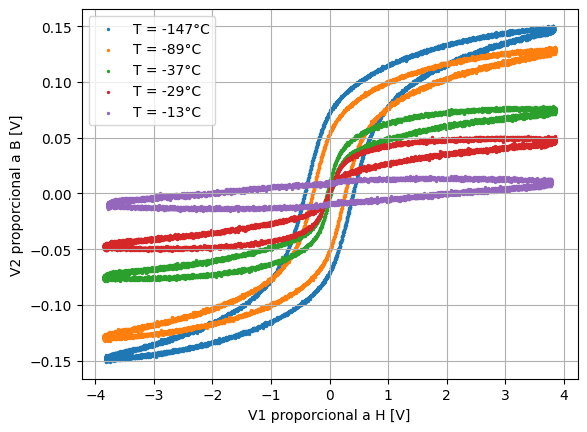

In [ ]:
R0 = 100 # esta definida así, le pregunte al chagpt
alpha = 0.00385 # coeficiente de temperatura del platino
T = []
listaresist = []

lista_archivos_selected = [17,5,55,45,0]

for i in range(len(lista_archivos_selected)):
    archivo = archivos_csv[lista_archivos_selected[i]]
    df = pd.read_csv(archivo)  # Leer CSV
    H = df["tension_entrada"]
    B = df["tension_integrada"]-np.mean(df["tension_integrada"])
    resistencia = df["resistencia"]/10000
    listaresist.append(resistencia[0])
    #-------------------------- Calcular Temp ------------------------------
    T_calc = (resistencia[0] - R0)/(alpha * R0)
    T.append(T_calc.mean())
    plt.scatter(H, B, s=2, label=f"T = {int(T[i])}°C")
    plt.legend()
plt.xlabel("V1 proporcional a H [V]")
plt.ylabel("V2 proporcional a B [V]")
plt.grid()

# Relación Temperatura y Resistencia

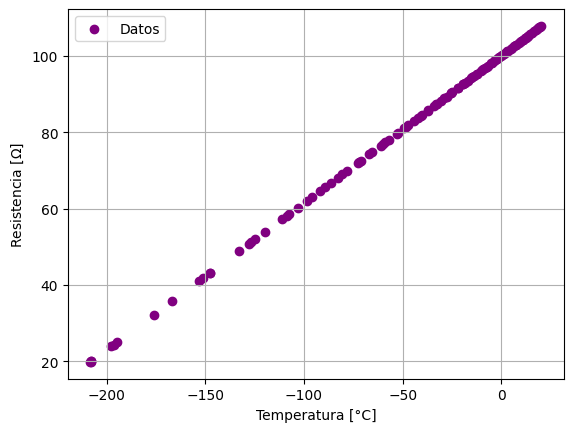

In [ ]:
R0 = 100 # esta definida así, le pregunte al chagpt
alpha = 0.00385 # coeficiente de temperatura del platino
T = []
listaresist = [] #en esta lista me guardo en cada posición la resistencia de cada archivo

for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    resistencia = df["resistencia"]/10000
    listaresist.append(resistencia[0])
    #-------------------------- Calcular Temp ------------------------------
    T_calc = (resistencia[0] - R0)/(alpha * R0)
    T.append(T_calc.mean())

plt.scatter(T, listaresist, label='Datos', color = "purple")
plt.xlabel('Temperatura [°C]')
plt.ylabel('Resistencia [$\Omega$]')
plt.grid()
plt.legend()
plt.show()

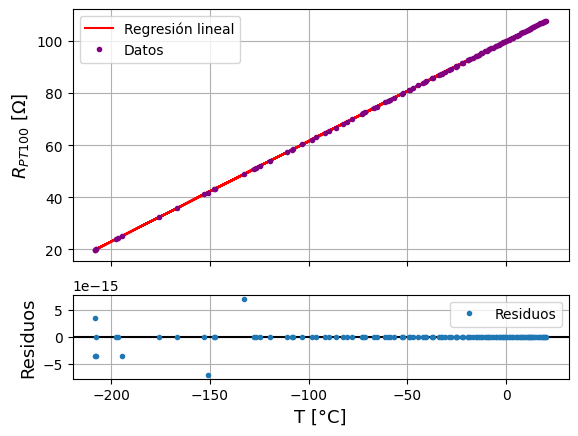

(0.385, 1.7547633179342917e-18, 100.0, 1.3836707006980221e-16)

In [ ]:
R0 = 100 # esta definida así, le pregunte al chagpt
alpha = 0.00385 # coeficiente de temperatura del platino
T = []
listaresist = [] #en esta lista me guardo en cada posición la resistencia de cada archivo

for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    resistencia = df["resistencia"]/10000
    listaresist.append(resistencia[0])
    #-------------------------- Calcular Temp ------------------------------
    T_calc = (resistencia[0] - R0)/(alpha * R0)
    T.append(T_calc.mean())

def lineal(x, m, b):
    return m * x +b

x = T
y = listaresist
xerr = 0
yerr = 0

p_opt, p_cov = curve_fit(lineal, x, y)
m_optimo = p_opt[0]
b_optimo = p_opt[1]
b_error = p_cov[1,1]**0.5
m_error = p_cov[0,0]**0.5

m_optimo,m_error #pendiente y error

y_predicho = lineal(x,np.array(m_optimo),np.array(b_optimo)) #lineal
residuos = y - y_predicho


#grafiquemos

fig, ax = plt.subplots(2, sharex = True, gridspec_kw={'height_ratios': [3, 1]})


ax[0].errorbar(x, y_predicho, label="Regresión lineal", color = "red")
ax[0].errorbar(x, y, fmt = ".", capsize = 5, label = "Datos", color = "purple")
ax[1].errorbar(x, residuos, fmt = ".", label = "Residuos")

# plt.xlabel("Título x []", fontsize = 15)
# plt.ylabel("Título y []", fontsize = 15)

ax[0].set_ylabel("$R_{PT100}$ [$\Omega$]", fontsize = 13)
ax[1].set_ylabel("Residuos", fontsize = 13)
ax[1].set_xlabel("T [°C]", fontsize = 13)
# ax[1].set_ylim(-0.0005, 0.0005)

# major_ticks = np.arange(x[0], x[len(x)-1], 0.05 )
# minor_ticks = np.arange(x[0], x[len(x)-1], 0.05)

# ax[0].set_xticks(major_ticks)
# ax[0].set_xticks(minor_ticks, minor=True)
# ax[0].grid(which='minor', alpha=0.2)
# ax[0].grid(which='major', alpha=0.6)

ax[1].axhline(0, color = "black")
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
plt.show()

m_optimo, m_error, b_optimo, b_error

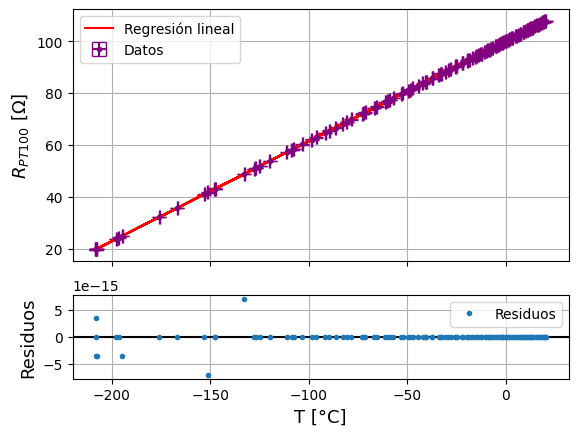

Pendiente: 0.385 ± 1.7547633179342917e-18
Intercepto: 100.0 ± 1.3836707006980221e-16


In [ ]:
R0 = 100  # Valor nominal de la resistencia a 0°C
alpha = 0.00385  # Coeficiente de temperatura del platino
sigma_R = 0.1  # Incertidumbre en la resistencia medida (ajustar según corresponda)

T = []
listaresist = []  # Lista para almacenar las resistencias
T_error = []  # Lista para almacenar los errores de temperatura

for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    resistencia = df["resistencia"] / 10000
    listaresist.append(resistencia[0])

    # Calcular temperatura
    T_calc = (resistencia[0] - R0) / (alpha * R0)
    T.append(T_calc.mean())

    # Propagación de errores
    sigma_T = sigma_R / (alpha * R0)
    T_error.append(sigma_T)

def lineal(x, m, b):
    return m * x + b

x = np.array(T)
y = np.array(listaresist)
xerr = np.array(T_error)
yerr = sigma_R  # Asumimos que el error en la resistencia es constante

p_opt, p_cov = curve_fit(lineal, x, y) # curve fit : ajuste por cuadrados mínimos
m_optimo = p_opt[0]
b_optimo = p_opt[1]
b_error = np.sqrt(p_cov[1, 1])
m_error = np.sqrt(p_cov[0, 0])

y_predicho = lineal(x, m_optimo, b_optimo)  # Recta de regresión
residuos = y - y_predicho

# Graficar
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].errorbar(x, y_predicho, label="Regresión lineal", color="red")
ax[0].errorbar(x, y, yerr=yerr, xerr=xerr, fmt=".", capsize=5, label="Datos", color="purple")
ax[1].errorbar(x, residuos, fmt=".", label="Residuos")

ax[0].set_ylabel("$R_{PT100}$ [$\\Omega$]", fontsize=13)
ax[1].set_ylabel("Residuos", fontsize=13)
ax[1].set_xlabel("T [°C]", fontsize=13)
ax[1].axhline(0, color="black")
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
plt.show()

print(f"Pendiente: {m_optimo} ± {m_error}")
print(f"Intercepto: {b_optimo} ± {b_error}")

0.6369657686129124
La temperatura de Curie es de T_c = (-28.0 ± 1.0)°C
Chi-cuadrado (χ²): 43.5438
Chi-cuadrado reducido (χ²/ν): 1.1769
p-valor: 0.2129


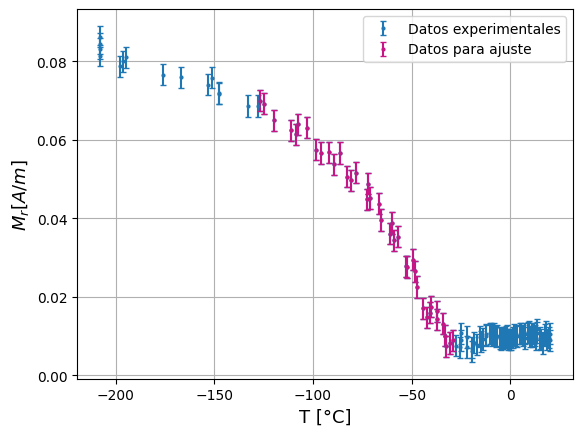

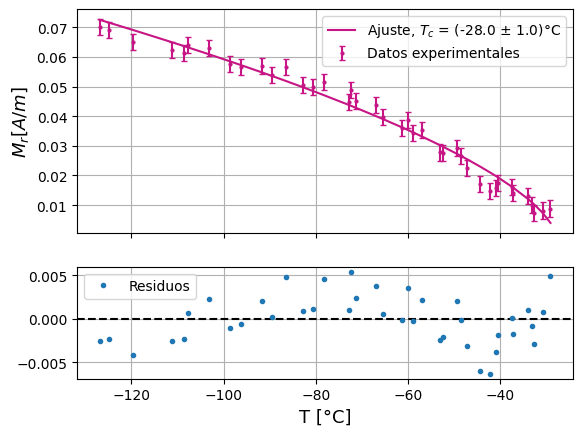

In [ ]:
Mr = []
from scipy.interpolate import interp1d
from scipy.stats import chi2

#------------------------- Leer los archivos uno por uno---------------------
for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    H = df["tension_entrada"]
    B = df["tension_integrada"] - np.mean(df["tension_integrada"])
    #-------------------------- Busco Mr ------------------------------
    # Inicializar la distancia mínima con un valor grande
    min_distancia = float('inf')
    posicion = 0

    # Recorrer la lista para encontrar el valor más cercano a 0
    for i, valor in enumerate(H):
        distancia = abs(valor)  # Distancia absoluta respecto a 0
        if distancia < min_distancia and B[i] > 0:
            min_distancia = distancia
            posicion = i
    Mr.append(B[posicion])

# Emparejar las listas de temperatura y magnetización
pares = list(zip(T, Mr))
pares_ordenados = sorted(pares, key=lambda x: x[0]) # Ordenar los pares por la temperatura (primer elemento de cada tupla)
T_ordenadas, Mr_ordenadas = zip(*pares_ordenados) # Desempaquetar las listas ordenadas

# Convertir de nuevo a listas si es necesario
T_ordenadas = list(T_ordenadas)
Mr_ordenadas = list(Mr_ordenadas)

for i in range(len(Mr_ordenadas)):
    if i > 47 and i < 60:
        Mr_ordenadas[i] = Mr_ordenadas[i] + 0.007 #arreglo ese pozo que se hace
"""
plt.scatter(T_ordenadas, Mr_ordenadas, label='Datos', color="blue")
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.legend()
plt.show()
"""
#-------------------------- Calcular Temp Curie ------------------------------
errorMr = 2.71e-3
def tempcurie(T, Tc, beta, A):
    return A*(np.abs(T - Tc)) ** beta

#plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumblue")
#plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumvioletred")

p_opt, p_cov = curve_fit(tempcurie, T_ordenadas[15:55], Mr_ordenadas[15:55],sigma=errorMr, absolute_sigma=True,p0=[-10, 0.3,0.07]) #nomás agarro la porcion de los datos en rojito
Tc_ajustado, beta_ajustado, A_ajustado = p_opt
error_popt = np.sqrt(np.diag(p_cov))  # Errores en Tc, beta y A
print(beta_ajustado)

# Graficar los datos y la curva ajustada
T_fit = np.linspace(min(T_ordenadas[15:55]), max(T_ordenadas[15:55]), 100)
Mr_fit = tempcurie(T_fit, Tc_ajustado, beta_ajustado, A_ajustado)
#plt.plot(T_fit, Mr_fit, label='Curva ajustada', color='mediumvioletred')
"""
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.title('Ajuste de la ecuación Mr = (T - Tc)^beta')
plt.legend()
plt.show()
"""

# Predicción y residuos
#y_predicho = tempcurie(T_ordenadas[0:55], *p_opt)
#residuos = Mr_ordenadas[0:55] - y_predicho
y_predicho = tempcurie(T_ordenadas[15:55], *p_opt)
residuos = Mr_ordenadas[15:55] - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorMr) ** 2)
dof = len(T_ordenadas[15:55]) - len(p_opt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"La temperatura de Curie es de T_c = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2)
plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos para ajuste', capsize=2, markersize=2, color = "mediumvioletred")
plt.xlabel('T [°C]', fontsize=13)
plt.ylabel('$M_r[A/m]$', fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

# Gráficos Zoom
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

ax[0].errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2, color = "mediumvioletred")
#ax[0].plot(T_ordenadas[15:55], y_predicho[15:55], label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")
ax[0].plot(T_ordenadas[15:55], y_predicho, label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")


#ax[1].errorbar(T_ordenadas[15:55], residuos[15:55], fmt=".", label="Residuos")
ax[1].errorbar(T_ordenadas[15:55], residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('T [°C]', fontsize=13)
ax[0].set_ylabel('$M_r[A/m]$', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()


La temperatura de Curie es de T_c = (-28.0 ± 1.3)°C
Chi-cuadrado (χ²): 23.2336
Chi-cuadrado reducido (χ²/ν): 0.6279
p-valor: 0.9622
beta: 0.6370  ± 0.0 
A: 0.0039  ± 0.0


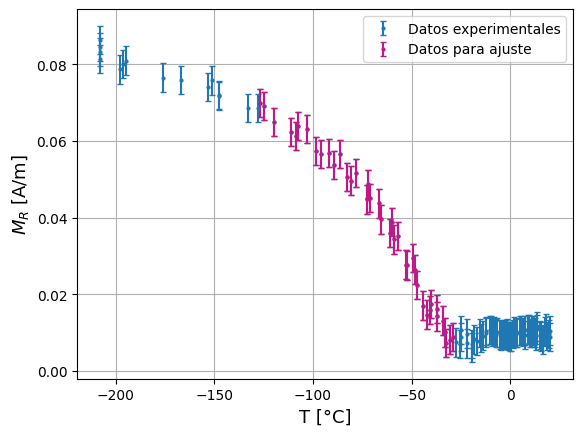

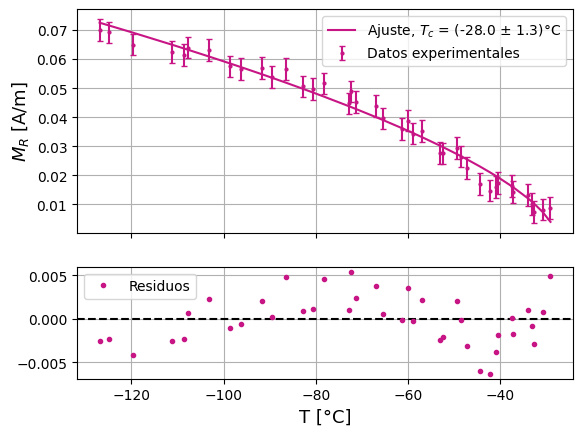

In [45]:
Mr = []
from scipy.interpolate import interp1d
from scipy.stats import chi2

#------------------------- Leer los archivos uno por uno---------------------
for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    H = df["tension_entrada"]
    B = df["tension_integrada"] - np.mean(df["tension_integrada"])
    #-------------------------- Busco Mr ------------------------------
    # Inicializar la distancia mínima con un valor grande
    min_distancia = float('inf')
    posicion = 0

    # Recorrer la lista para encontrar el valor más cercano a 0
    for i, valor in enumerate(H):
        distancia = abs(valor)  # Distancia absoluta respecto a 0
        if distancia < min_distancia and B[i] > 0:
            min_distancia = distancia
            posicion = i
    Mr.append(B[posicion])

# Emparejar las listas de temperatura y magnetización
pares = list(zip(T, Mr))
pares_ordenados = sorted(pares, key=lambda x: x[0]) # Ordenar los pares por la temperatura (primer elemento de cada tupla)
T_ordenadas, Mr_ordenadas = zip(*pares_ordenados) # Desempaquetar las listas ordenadas

# Convertir de nuevo a listas si es necesario
T_ordenadas = list(T_ordenadas)
Mr_ordenadas = list(Mr_ordenadas)

for i in range(len(Mr_ordenadas)):
    if i > 47 and i < 60:
        Mr_ordenadas[i] = Mr_ordenadas[i] + 0.007 #arreglo ese pozo que se hace
"""
plt.scatter(T_ordenadas, Mr_ordenadas, label='Datos', color="blue")
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.legend()
plt.show()
"""
#-------------------------- Calcular Temp Curie ------------------------------
errorMr = 3.71e-3
def tempcurie(T, Tc, beta, A):
    return A*(np.abs(T - Tc)) ** beta

#plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumblue")
#plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumvioletred")

p_opt, p_cov = curve_fit(tempcurie, T_ordenadas[15:55], Mr_ordenadas[15:55],sigma=errorMr, absolute_sigma=True,p0=[-10, 0.3,0.07]) #nomás agarro la porcion de los datos en rojito
Tc_ajustado, beta_ajustado, A_ajustado = p_opt
error_popt = np.sqrt(np.diag(p_cov))  # Errores en Tc, beta y A


# Graficar los datos y la curva ajustada
T_fit = np.linspace(min(T_ordenadas[15:55]), max(T_ordenadas[15:55]), 100)
Mr_fit = tempcurie(T_fit, Tc_ajustado, beta_ajustado, A_ajustado)
#plt.plot(T_fit, Mr_fit, label='Curva ajustada', color='mediumvioletred')
"""
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.title('Ajuste de la ecuación Mr = (T - Tc)^beta')
plt.legend()
plt.show()
"""

# Predicción y residuos
#y_predicho = tempcurie(T_ordenadas[0:55], *p_opt)
#residuos = Mr_ordenadas[0:55] - y_predicho
y_predicho = tempcurie(T_ordenadas[15:55], *p_opt)
residuos = Mr_ordenadas[15:55] - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorMr) ** 2)
dof = len(T_ordenadas[15:55]) - len(p_opt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"La temperatura de Curie es de T_c = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")
print(f"beta: {beta_ajustado:.4f}  ± {error_popt[1]:.1f} ")
print(f"A: {A_ajustado:.4f}  ± {error_popt[2]:.1f}")


# Gráficos
plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2)
plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos para ajuste', capsize=2, markersize=2, color = "mediumvioletred")
plt.xlabel('T [°C]', fontsize=13)
plt.ylabel('$M_R$ [A/m]', fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

# Gráficos Zoom
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

ax[0].errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2, color = "mediumvioletred")
#ax[0].plot(T_ordenadas[15:55], y_predicho[15:55], label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")
ax[0].plot(T_ordenadas[15:55], y_predicho, label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")


#ax[1].errorbar(T_ordenadas[15:55], residuos[15:55], fmt=".", label="Residuos")
ax[1].errorbar(T_ordenadas[15:55], residuos, fmt=".", label="Residuos", color = "mediumvioletred")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('T [°C]', fontsize=13)
ax[0].set_ylabel('$M_R$ [A/m]', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

La temperatura de Curie es de T_c = (-35.3 ± 0.5)°C
Chi-cuadrado (χ²): 29.6017
Chi-cuadrado reducido (χ²/ν): 1.0207
p-valor: 0.4341


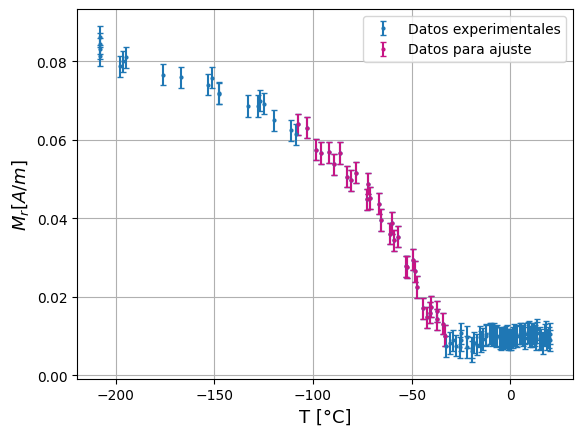

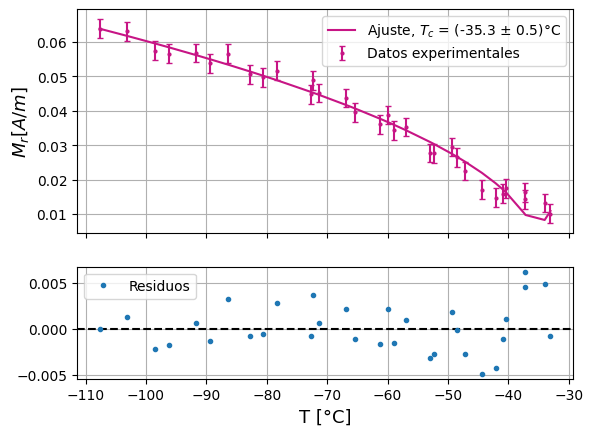

In [ ]:
Mr = []
from scipy.interpolate import interp1d
from scipy.stats import chi2

#------------------------- Leer los archivos uno por uno---------------------
for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    H = df["tension_entrada"]
    B = df["tension_integrada"] - np.mean(df["tension_integrada"])
    #-------------------------- Busco Mr ------------------------------
    # Inicializar la distancia mínima con un valor grande
    min_distancia = float('inf')
    posicion = 0

    # Recorrer la lista para encontrar el valor más cercano a 0
    for i, valor in enumerate(H):
        distancia = abs(valor)  # Distancia absoluta respecto a 0
        if distancia < min_distancia and B[i] > 0:
            min_distancia = distancia
            posicion = i
    Mr.append(B[posicion])

# Emparejar las listas de temperatura y magnetización
pares = list(zip(T, Mr))
pares_ordenados = sorted(pares, key=lambda x: x[0]) # Ordenar los pares por la temperatura (primer elemento de cada tupla)
T_ordenadas, Mr_ordenadas = zip(*pares_ordenados) # Desempaquetar las listas ordenadas

# Convertir de nuevo a listas si es necesario
T_ordenadas = list(T_ordenadas)
Mr_ordenadas = list(Mr_ordenadas)

for i in range(len(Mr_ordenadas)):
    if i > 47 and i < 60:
        Mr_ordenadas[i] = Mr_ordenadas[i] + 0.007 #arreglo ese pozo que se hace
"""
plt.scatter(T_ordenadas, Mr_ordenadas, label='Datos', color="blue")
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.legend()
plt.show()
"""
#-------------------------- Calcular Temp Curie ------------------------------
errorMr = 2.71e-3
def tempcurie(T, Tc, beta, A):
    return A*(np.abs(T - Tc)) ** beta

#plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumblue")
#plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumvioletred")

p_opt, p_cov = curve_fit(tempcurie, T_ordenadas[20:52], Mr_ordenadas[20:52],sigma=errorMr, absolute_sigma=True,p0=[-10, 0.3,0.07]) #nomás agarro la porcion de los datos en rojito
Tc_ajustado, beta_ajustado, A_ajustado = p_opt
error_popt = np.sqrt(np.diag(p_cov))  # Errores en Tc, beta y A


# Graficar los datos y la curva ajustada
T_fit = np.linspace(min(T_ordenadas[20:52]), max(T_ordenadas[20:52]), 100)
Mr_fit = tempcurie(T_fit, Tc_ajustado, beta_ajustado, A_ajustado)
#plt.plot(T_fit, Mr_fit, label='Curva ajustada', color='mediumvioletred')
"""
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.title('Ajuste de la ecuación Mr = (T - Tc)^beta')
plt.legend()
plt.show()
"""

# Predicción y residuos
#y_predicho = tempcurie(T_ordenadas[0:55], *p_opt)
#residuos = Mr_ordenadas[0:55] - y_predicho
y_predicho = tempcurie(T_ordenadas[20:52], *p_opt)
residuos = Mr_ordenadas[20:52] - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorMr) ** 2)
dof = len(T_ordenadas[20:52]) - len(p_opt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"La temperatura de Curie es de T_c = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2)
plt.errorbar(T_ordenadas[20:52], Mr_ordenadas[20:52], yerr=errorMr, fmt='o', label='Datos para ajuste', capsize=2, markersize=2, color = "mediumvioletred")
plt.xlabel('T [°C]', fontsize=13)
plt.ylabel('$M_r[A/m]$', fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

# Gráficos Zoom
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

ax[0].errorbar(T_ordenadas[20:52], Mr_ordenadas[20:52], yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2, color = "mediumvioletred")
#ax[0].plot(T_ordenadas[15:55], y_predicho[15:55], label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")
ax[0].plot(T_ordenadas[20:52], y_predicho, label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")


#ax[1].errorbar(T_ordenadas[15:55], residuos[15:55], fmt=".", label="Residuos")
ax[1].errorbar(T_ordenadas[20:52], residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('T [°C]', fontsize=13)
ax[0].set_ylabel('$M_r[A/m]$', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

La temperatura de Curie es de T_c = (-28.0 ± 1.0)°C
Chi-cuadrado (χ²): 43.5438
Chi-cuadrado reducido (χ²/ν): 1.1769
p-valor: 0.2129


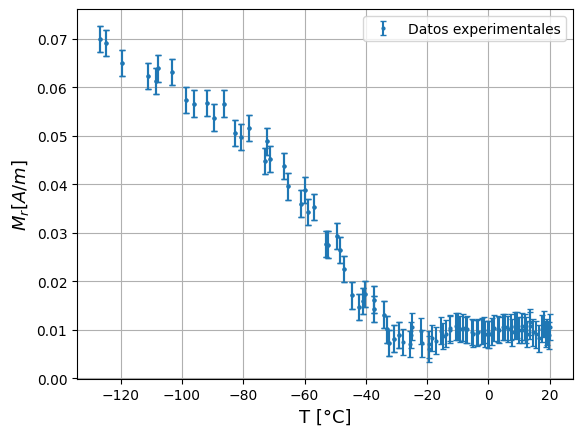

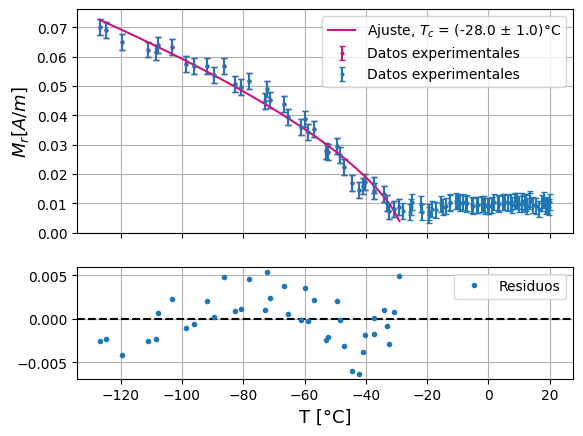

In [ ]:
Mr = []
from scipy.interpolate import interp1d
from scipy.stats import chi2

#------------------------- Leer los archivos uno por uno---------------------
for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    H = df["tension_entrada"]
    B = df["tension_integrada"] - np.mean(df["tension_integrada"])
    #-------------------------- Busco Mr ------------------------------
    # Inicializar la distancia mínima con un valor grande
    min_distancia = float('inf')
    posicion = 0

    # Recorrer la lista para encontrar el valor más cercano a 0
    for i, valor in enumerate(H):
        distancia = abs(valor)  # Distancia absoluta respecto a 0
        if distancia < min_distancia and B[i] > 0:
            min_distancia = distancia
            posicion = i
    Mr.append(B[posicion])

# Emparejar las listas de temperatura y magnetización
pares = list(zip(T, Mr))
pares_ordenados = sorted(pares, key=lambda x: x[0]) # Ordenar los pares por la temperatura (primer elemento de cada tupla)
T_ordenadas, Mr_ordenadas = zip(*pares_ordenados) # Desempaquetar las listas ordenadas

# Convertir de nuevo a listas si es necesario
T_ordenadas = list(T_ordenadas)
Mr_ordenadas = list(Mr_ordenadas)

for i in range(len(Mr_ordenadas)):
    if i > 47 and i < 60:
        Mr_ordenadas[i] = Mr_ordenadas[i] + 0.007 #arreglo ese pozo que se hace
"""
plt.scatter(T_ordenadas, Mr_ordenadas, label='Datos', color="blue")
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.legend()
plt.show()
"""
#-------------------------- Calcular Temp Curie ------------------------------
errorMr = 2.71e-3
def tempcurie(T, Tc, beta, A):
    return A*(np.abs(T - Tc)) ** beta

#plt.errorbar(T_ordenadas, Mr_ordenadas, yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumblue")
#plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos', capsize=4, markersize=4, color = "mediumvioletred")

p_opt, p_cov = curve_fit(tempcurie, T_ordenadas[15:55], Mr_ordenadas[15:55],sigma=errorMr, absolute_sigma=True,p0=[-10, 0.3,0.07]) #nomás agarro la porcion de los datos en rojito
Tc_ajustado, beta_ajustado, A_ajustado = p_opt
error_popt = np.sqrt(np.diag(p_cov))  # Errores en Tc, beta y A


# Graficar los datos y la curva ajustada
T_fit = np.linspace(min(T_ordenadas[15:55]), max(T_ordenadas[15:55]), 100)
Mr_fit = tempcurie(T_fit, Tc_ajustado, beta_ajustado, A_ajustado)
#plt.plot(T_fit, Mr_fit, label='Curva ajustada', color='mediumvioletred')
"""
plt.xlabel('T [°C]')
plt.ylabel('$M_r$ [A/m]')
plt.grid()
plt.title('Ajuste de la ecuación Mr = (T - Tc)^beta')
plt.legend()
plt.show()
"""

# Predicción y residuos
#y_predicho = tempcurie(T_ordenadas[0:55], *p_opt)
#residuos = Mr_ordenadas[0:55] - y_predicho
y_predicho = tempcurie(T_ordenadas[15:55], *p_opt)
residuos = Mr_ordenadas[15:55] - y_predicho

# Cálculo del Chi-cuadrado
chi2_valor = np.sum((residuos / errorMr) ** 2)
dof = len(T_ordenadas[15:55]) - len(p_opt)  # Grados de libertad
chi2_reducido = chi2_valor / dof
p_valor = chi2.sf(chi2_valor, dof)

print(f"La temperatura de Curie es de T_c = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C")
print(f"Chi-cuadrado (χ²): {chi2_valor:.4f}")
print(f"Chi-cuadrado reducido (χ²/ν): {chi2_reducido:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Gráficos
plt.errorbar(T_ordenadas[15::], Mr_ordenadas[15::], yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2, color ="#1f77b4")
plt.errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', capsize=2, markersize=2, color ="#1f77b4")
plt.xlabel('T [°C]', fontsize=13)
plt.ylabel('$M_r[A/m]$', fontsize=13)
plt.grid(True)
plt.legend()
plt.show()

# Gráficos Zoom
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

ax[0].errorbar(T_ordenadas[15:55], Mr_ordenadas[15:55], yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2, color = "mediumvioletred")
#ax[0].plot(T_ordenadas[15:55], y_predicho[15:55], label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")
ax[0].errorbar(T_ordenadas[15::], Mr_ordenadas[15::], yerr=errorMr, fmt='o', label='Datos experimentales', capsize=2, markersize=2, color ="#1f77b4")
ax[0].plot(T_ordenadas[15:55], y_predicho, label=f'Ajuste, $T_c$ = ({Tc_ajustado:.1f} ± {error_popt[0]:.1f})°C',color = "mediumvioletred")


#ax[1].errorbar(T_ordenadas[15:55], residuos[15:55], fmt=".", label="Residuos")
ax[1].errorbar(T_ordenadas[15:55], residuos, fmt=".", label="Residuos")
ax[1].axhline(0, color="black", linestyle="--")

ax[1].set_xlabel('T [°C]', fontsize=13)
ax[0].set_ylabel('$M_r[A/m]$', fontsize=13)

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
plt.show()

0.013247900782731022
0.00271


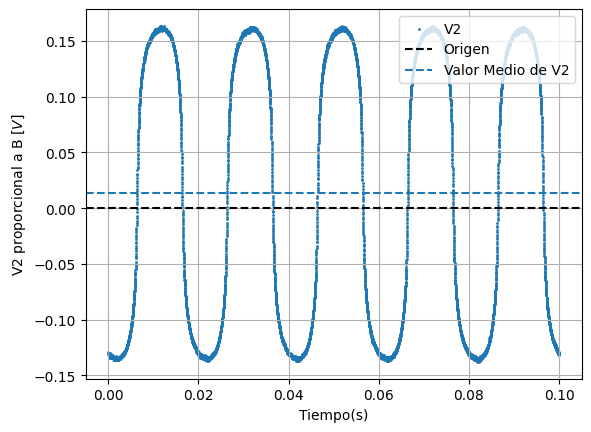

In [ ]:
for archivo in archivos_csv:
    df = pd.read_csv(archivo)  # Cargar CSV en un DataFrame
    V1 = df["tension_entrada"]
    V2 = df["tension_integrada"]
    tiempos = df["tiempo"]
    if archivo == archivos_csv[17]:
        #plt.scatter(tiempos, V1, label='V1', color = "purple", s=1)
        plt.scatter(tiempos, V2, label='V2', s=1)
        plt.axhline(y=0, color='black', linestyle='--', label="Origen")
        plt.axhline(y=np.mean(V2), linestyle='--', label="Valor Medio de V2")
        print(np.mean(V2))
        print(2.71e-3)
        plt.xlabel('Tiempo(s)')
        plt.ylabel('V2 proporcional a B [$V$]')
        plt.grid()
        plt.legend(loc="upper right")
        plt.show()

